In [1]:
import pandas as pd
import numpy as np
from typing import List

In [2]:
adj = pd.read_csv('adj.txt', header=None)
# make adj matrix
adj_matrix = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
    for j in range(len(adj)):
        if i == j:
            continue
        if str(j) in adj.iloc[i,0].split(' '):
            adj_matrix[i,j] = 1
            adj_matrix[j,i] = 1
# label            
label = np.loadtxt('karate_label.txt')

In [27]:
adj_matrix

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [4]:
label

array([[ 0.,  1.],
       [ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       [ 4.,  1.],
       [ 5.,  1.],
       [ 6.,  1.],
       [ 7.,  1.],
       [ 8.,  0.],
       [ 9.,  0.],
       [10.,  1.],
       [11.,  1.],
       [12.,  1.],
       [13.,  1.],
       [14.,  0.],
       [15.,  0.],
       [16.,  1.],
       [17.,  1.],
       [18.,  0.],
       [19.,  1.],
       [20.,  0.],
       [21.,  1.],
       [22.,  0.],
       [23.,  0.],
       [24.,  0.],
       [25.,  0.],
       [26.,  0.],
       [27.,  0.],
       [28.,  0.],
       [29.,  0.],
       [30.,  0.],
       [31.,  0.],
       [32.,  0.],
       [33.,  0.]])

In [12]:
class DeepWalk:
    def __init__(self,
                 adj_matrix,
                 embedding_dim=2,
                 walks_per_vertex=5,
                 walk_len=10,
                 window_size=3,
                 learning_rate=0.02):
        
        self.adj_matrix = adj_matrix
        self.embedding_dim = embedding_dim
        self.walks_per_vertex = walks_per_vertex
        self.walk_len = walk_len
        self.window_size = window_size
        self.learning_rate = learning_rate
        
        self.w1 = np.random.rand(len(adj_matrix),embedding_dim)
        self.w2 = np.random.rand(embedding_dim,len(adj_matrix))
        
        self.epoch_loss = 0.0
    
    def _random_walk(self, start_node: int)-> List:
        walk = [0] * self.walk_len
        walk[0] = start_node
        node = start_node
        for i in range(1, self.walk_len):
            next_node = np.random.choice(np.where(self.adj_matrix[node]==1)[0])
            walk[i] = next_node
            node = next_node
        return walk

    def _softmax(self, a: np.array)-> np.array : 
        c = np.max(a) 
        exp_a = np.exp(a-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def _skip_gram_train(self, walk: List)-> None:
        for idx, input_node in enumerate(walk):
            # make dataset
            left_idx = idx - 3
            right_idx = idx + 3
            if left_idx < 0: left_idx = 0
            if right_idx > self.walk_len-1: right_idx = self.walk_len
            left_node = walk[left_idx:idx]
            right_node = walk[idx+1:right_idx+1]
            output_node = left_node + right_node

            # forward
            hidden = self.w1[input_node]
            ## |hidden| = (2,)
            out = np.matmul(hidden, self.w2)
            ## |out| = (34,)

            # loss calculate
            self.epoch_loss += (-np.sum(out[output_node]) \
                                   + len(output_node)*np.log(np.sum(np.exp(out))))\
                                / (self.walk_len*self.walks_per_vertex*len(self.adj_matrix)) 

            # backprop and optimize
            dEdo = self._softmax(out) * len(output_node)
            dEdo[output_node] = dEdo[output_node] - 1.0 - self._softmax(out)[output_node]
            dEdw2 = np.matmul(hidden.reshape(2,1), dEdo.reshape(1,34))
            self.w2 = self.w2 - self.learning_rate * dEdw2
            self.w1[input_node] = self.w1[input_node] - \
                self.learning_rate * np.matmul(self.w2, dEdo)

    def train(self)-> float:
        self.epoch_loss = 0.0
        V = np.arange(0, len(self.adj_matrix))
        for _ in range(self.walks_per_vertex):
            # shuffle vertex
            np.random.shuffle(V)
            for start_node in V:
                # random walk
                W = self._random_walk(start_node)
                # skip-gram
                self._skip_gram_train(W)
        return self.epoch_loss
    
    def show_embedding(self):
        return self.w1, self.w2

In [40]:
model = DeepWalk(adj_matrix, walks_per_vertex=3, walk_len=10, window_size=3, learning_rate=0.003)
n_epochs = 30
losses = []
# train
for i in range(1, n_epochs+1):
    loss = model.train()
    losses.append(loss)
    print(f'Epoch:{i}, loss={loss:.3f}')

Epoch:1, loss=16.618
Epoch:2, loss=16.245
Epoch:3, loss=16.046
Epoch:4, loss=15.907
Epoch:5, loss=15.640
Epoch:6, loss=15.697
Epoch:7, loss=15.219
Epoch:8, loss=15.149
Epoch:9, loss=14.874
Epoch:10, loss=14.770
Epoch:11, loss=14.622
Epoch:12, loss=14.334
Epoch:13, loss=14.164
Epoch:14, loss=14.399
Epoch:15, loss=14.183
Epoch:16, loss=13.918
Epoch:17, loss=14.000
Epoch:18, loss=14.064
Epoch:19, loss=13.941
Epoch:20, loss=13.958
Epoch:21, loss=13.708
Epoch:22, loss=13.773
Epoch:23, loss=13.996
Epoch:24, loss=13.893
Epoch:25, loss=14.001
Epoch:26, loss=13.897
Epoch:27, loss=13.775
Epoch:28, loss=13.970
Epoch:29, loss=14.071
Epoch:30, loss=13.801


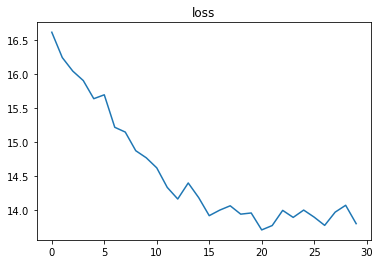

In [41]:
import matplotlib.pyplot as plt
plt.title('loss')
plt.plot(losses)

In [42]:
embedding_matrix, _ = model.show_embedding()

In [43]:
embedding_matrix.shape

(34, 2)

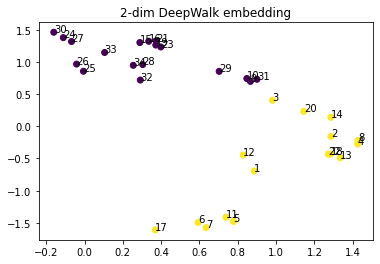

In [44]:
plt.title('2-dim DeepWalk embedding')
plt.scatter(embedding_matrix[:,0],embedding_matrix[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(embedding_matrix[i,0]), float(embedding_matrix[i,1]), i+1 , fontsize=10)
plt.show()